# Question 2: Neural Machine Translation with Attention Mechanisms

## Imports and Setup
Imports necessary libraries (PyTorch, SpaCy, datasets) and sets random seeds for reproducibility.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import math
import time
import random
from tqdm import tqdm
import numpy as np

# Load Hugging Face datasets
from datasets import load_dataset

# Load spaCy for tokenization
import spacy

# Set random seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Configure device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


Device: cuda


## Dataset Loading and Tokenization
Loads the Multi30k German-English dataset from Hugging Face and applies SpaCy tokenization to both source and target languages.

In [ ]:
# Load spaCy language models
try:
    spacy_de = spacy.load('de_core_news_sm')  # Source: German
    spacy_en = spacy.load('en_core_web_sm')  # Target: English
    print("  spaCy language models loaded successfully")
except IOError:
    print("\n--- ERROR ---")
    print("spaCy models not found. Please run installation commands.")

# Load Multi30k dataset from Hugging Face
DATASET_ID = "bentrevett/multi30k"
print(f"\n'{DATASET_ID}' dataset loading from Hugging Face Hub...")

try:
    # Load dataset splits
    dataset = load_dataset(DATASET_ID)

    # Rename validation split to 'valid'
    dataset['valid'] = dataset.pop('validation')

    print("Dataset loaded:")
    print(dataset)

    print("\nSample data (train[0]):")
    print(dataset['train'][0])

except Exception as e:
    print(f"\nError loading dataset: {e}")
    print("Will try Method 2 (Pandas).")
    dataset = None

# Define tokenization function
def tokenize_example(example):
    """Tokenize source and target sequences."""
    src_tokens = [tok.text for tok in spacy_de.tokenizer(example['de'].lower())]
    trg_tokens = [tok.text for tok in spacy_en.tokenizer(example['en'].lower())]
    return {'src_tokens': src_tokens, 'trg_tokens': trg_tokens}

if dataset:
    print("\nTokenizer function defined. Applying to dataset...")
    tokenized_datasets = dataset.map(tokenize_example, batched=False)

    print("\nTokenized dataset:")
    print(tokenized_datasets)
    print("\nTokenized example (train[0]):")
    print(tokenized_datasets['train'][0])
else:
    print("\nDataset loading failed. Skipping tokenization.")

  spaCy language models loaded successfully

'bentrevett/multi30k' dataset loading from Hugging Face Hub...
Dataset loaded:
DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
    valid: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
})

Sample data (train[0]):
{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'}

Tokenizer function defined. Applying to dataset...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]


Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['en', 'de', 'src_tokens', 'trg_tokens'],
        num_rows: 29000
    })
    test: Dataset({
        features: ['en', 'de', 'src_tokens', 'trg_tokens'],
        num_rows: 1000
    })
    valid: Dataset({
        features: ['en', 'de', 'src_tokens', 'trg_tokens'],
        num_rows: 1014
    })
})

Tokenized example (train[0]):
{'en': 'Two young, White males are outside near many bushes.', 'de': 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'src_tokens': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg_tokens': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


## Vocabulary Building
Creates source (German) and target (English) vocabularies with special tokens (UNK, PAD, SOS, EOS) and minimum frequency filtering.

In [3]:
from collections import Counter

# Define special tokens
UNK_TOKEN = '<unk>'  # Unknown word
PAD_TOKEN = '<pad>'  # Padding token
SOS_TOKEN = '<sos>'  # Start of sentence
EOS_TOKEN = '<eos>'  # End of sentence
special_tokens = [UNK_TOKEN, PAD_TOKEN, SOS_TOKEN, EOS_TOKEN]
MIN_FREQ = 2  # Minimum frequency threshold

# Build source (German) vocabulary
src_counter = Counter()
for example in tokenized_datasets['train']:
    src_counter.update(example['src_tokens'])

src_itos = list(special_tokens)
src_itos.extend([token for token, freq in src_counter.items() if freq >= MIN_FREQ])
src_stoi = {token: i for i, token in enumerate(src_itos)}
UNK_IDX = src_stoi[UNK_TOKEN]

# Build target (English) vocabulary
trg_counter = Counter()
for example in tokenized_datasets['train']:
    trg_counter.update(example['trg_tokens'])

trg_itos = list(special_tokens)
trg_itos.extend([token for token, freq in trg_counter.items() if freq >= MIN_FREQ])
trg_stoi = {token: i for i, token in enumerate(trg_itos)}
TRG_UNK_IDX = trg_stoi[UNK_TOKEN]

print(f"  Vocabularies built: DE={len(src_stoi)}, EN={len(trg_stoi)}")


# Store important indices
PAD_IDX = src_stoi[PAD_TOKEN]
SOS_IDX = src_stoi[SOS_TOKEN]
EOS_IDX = src_stoi[EOS_TOKEN]

print(f"\n  Special tokens: UNK(DE)={UNK_IDX}, PAD={PAD_IDX}, SOS={SOS_IDX}")
# Assign vocabularies for later use
src_vocab = src_stoi
trg_vocab = trg_stoi


  Vocabularies built: DE=7853, EN=5893

  Special tokens: UNK(DE)=0, PAD=1, SOS=2


## DataLoader Setup
Defines custom collate function for variable-length sequences and creates train/valid/test DataLoaders with padding.

In [4]:
def collate_fn(batch):
    """Custom collate function for variable-length sequences."""
    src_batch, trg_batch = [], []

    for example in batch:
        # Extract token lists
        src_tokens = example['src_tokens']
        trg_tokens = example['trg_tokens']

        # Convert tokens to indices
        src_indices = [src_vocab.get(token, UNK_IDX) for token in src_tokens]
        trg_indices = [trg_vocab.get(token, TRG_UNK_IDX) for token in trg_tokens]

        # Add SOS/EOS tokens
        src_processed = torch.tensor([SOS_IDX] + src_indices + [EOS_IDX], dtype=torch.long)
        trg_processed = torch.tensor([SOS_IDX] + trg_indices + [EOS_IDX], dtype=torch.long)

        # Move to device
        src_batch.append(src_processed.to(device))
        trg_batch.append(trg_processed.to(device))

    # Pad sequences to [seq_len, batch_size]
    src_padded = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_padded = pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_padded, trg_padded

# Create DataLoaders
BATCH_SIZE = 64

train_dataloader = DataLoader(tokenized_datasets['train'],
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=collate_fn)

valid_dataloader = DataLoader(tokenized_datasets['valid'],
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn)

test_dataloader = DataLoader(tokenized_datasets['test'],
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             collate_fn=collate_fn)

print(f"  DataLoaders created (batch_size={BATCH_SIZE})")


  DataLoaders created (batch_size=64)


## Encoder Architecture
Implements bidirectional GRU encoder with embedding layer and dropout for the shared backbone across all attention models.

In [5]:
# Model hyperparameters
INPUT_DIM = len(src_vocab)    # Source vocabulary size
OUTPUT_DIM = len(trg_vocab)   # Target vocabulary size
ENC_EMB_DIM = 256             # Encoder embedding dimension
DEC_EMB_DIM = 256             # Decoder embedding dimension
HID_DIM = 256                 # RNN hidden dimension
N_LAYERS = 2                  # Number of RNN layers
ENC_DROPOUT = 0.5             # Encoder dropout rate
DEC_DROPOUT = 0.5             # Decoder dropout rate

# Calculated dimensions for attention
ENC_HID_DIM_CALC = HID_DIM * 2  # Bidirectional encoder output
DEC_HID_DIM_CALC = HID_DIM      # Decoder hidden dimension
ATTN_DIM = 256                  # Attention dimension

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        # Embedding layer (trainable from scratch)
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx = PAD_IDX)

        # Bidirectional GRU
        self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout = dropout if n_layers > 1 else 0,
            bidirectional = True,
            batch_first = False
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src_len, batch_size]

        # Pass through embedding
        embedded = self.dropout(self.embedding(src))

        # Pass through RNN
        # outputs = [src_len, batch_size, hid_dim * 2]
        # hidden  = [n_layers * 2, batch_size, hid_dim]
        outputs, hidden = self.rnn(embedded)

        return outputs, hidden

print("  Encoder defined")


  Encoder defined


## Bahdanau (Additive) Attention
Implements Bahdanau attention mechanism using additive scoring with learnable weight matrices and tanh activation.

In [6]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, attn_dim):
        super().__init__()

        # Linear layers for Bahdanau attention
        self.attn_enc = nn.Linear(enc_hid_dim, attn_dim)  # Project encoder outputs
        self.attn_dec = nn.Linear(dec_hid_dim, attn_dim)  # Project decoder hidden
        self.v = nn.Linear(attn_dim, 1, bias = False)     # Energy to scalar

    def forward(self, decoder_hidden, encoder_outputs):

        # decoder_hidden  = [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # Reshape for alignment
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch, src_len, enc_hid]
        decoder_hidden = decoder_hidden.unsqueeze(1)         # [batch, 1, dec_hid]

        # Apply Bahdanau formula
        enc_proj = self.attn_enc(encoder_outputs)  # [batch, src_len, attn_dim]
        dec_proj = self.attn_dec(decoder_hidden)   # [batch, 1, attn_dim]

        # Combine with tanh activation
        combined_energy = torch.tanh(enc_proj + dec_proj)  # [batch, src_len, attn_dim]

        # Reduce to scalar scores
        energy = self.v(combined_energy).squeeze(2)  # [batch, src_len]

        # Apply softmax to get attention weights
        return F.softmax(energy, dim=1)

print("  Attention (Bahdanau) defined")


  Attention (Bahdanau) defined


## Decoder with Attention
Implements GRU decoder that uses attention-weighted context vectors combined with embeddings for prediction.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim,
                 dropout, n_layers, attention):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = dec_hid_dim
        self.n_layers = n_layers

        # Attention mechanism
        self.attention = attention

        # Embedding layer for target language
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx = PAD_IDX)

        # Decoder RNN (input = embedding + context)
        self.rnn = nn.GRU(
            input_size = emb_dim + enc_hid_dim,
            hidden_size = dec_hid_dim,
            num_layers = n_layers,
            dropout = dropout if n_layers > 1 else 0
        )

        # Output layer (combines RNN output + context + embedding)
        self.fc_out = nn.Linear(
            in_features = emb_dim + enc_hid_dim + dec_hid_dim,
            out_features = output_dim
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, decoder_hidden, encoder_outputs):

        # input_token     = [batch_size]
        # decoder_hidden  = [n_layers, batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim]

        # Reshape input token to [1, batch_size]
        input_token = input_token.unsqueeze(0)

        # Embedding
        embedded = self.dropout(self.embedding(input_token))  # [1, batch, emb_dim]

        # Get attention weights
        attn_weights = self.attention(decoder_hidden[-1], encoder_outputs)

        # Calculate weighted context
        attn_weights_unsqueezed = attn_weights.unsqueeze(1)  # [batch, 1, src_len]
        encoder_outputs_permuted = encoder_outputs.permute(1, 0, 2)  # [batch, src_len, enc_hid]

        # Batch matrix multiply
        weighted_context = torch.bmm(attn_weights_unsqueezed, encoder_outputs_permuted)
        weighted_context = weighted_context.permute(1, 0, 2)  # [1, batch, enc_hid]

        # Concatenate embedding and context
        rnn_input = torch.cat((embedded, weighted_context), dim=2)

        # Run RNN
        output, hidden = self.rnn(rnn_input, decoder_hidden)

        # Prepare for prediction
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_context = weighted_context.squeeze(0)

        # Combine all for prediction
        combined_for_pred = torch.cat((output, weighted_context, embedded), dim=1)

        # Final prediction
        prediction = self.fc_out(combined_for_pred)

        return prediction, hidden,attn_weights

print("  Decoder defined")


  Decoder defined


## Seq2Seq Model with Bridge
Combines encoder and decoder with a bridge layer to transform bidirectional encoder hidden states to unidirectional decoder hidden states.

In [ ]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, pad_idx):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.pad_idx = pad_idx

        # Bridge layer: bidirectional encoder -> unidirectional decoder
        self.fc_hidden = nn.Linear(encoder.hid_dim * 2, decoder.hid_dim)

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        # src = [src_len, batch_size]
        # trg = [trg_len, batch_size]

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # Store all decoder predictions
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # Step 1: Encode source sequence
        encoder_outputs, encoder_hidden = self.encoder(src)

        # Step 2: Bridge - transform encoder hidden to decoder hidden
        encoder_hidden = encoder_hidden.view(self.encoder.n_layers, 2, batch_size, self.encoder.hid_dim)
        encoder_hidden_cat = torch.cat((encoder_hidden[:, 0, :, :], encoder_hidden[:, 1, :, :]), dim=2)
        decoder_hidden = torch.tanh(self.fc_hidden(encoder_hidden_cat))

        # Step 3: Decode with teacher forcing
        input_token = trg[0, :] 

        for t in range(1, trg_len):

            # Decoder forward pass
            prediction, decoder_hidden, _ = self.decoder(
                input_token,
                decoder_hidden,
                encoder_outputs
            )

            # Store prediction
            outputs[t] = prediction

            # Teacher forcing: decide whether to use ground truth or prediction
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = prediction.argmax(1)  # Get predicted token

            input_token = trg[t] if teacher_force else top1

        return outputs

print("  Seq2Seq model defined")


  Seq2Seq model defined


## Training and Evaluation Functions
Defines train/evaluate functions with gradient clipping, loss calculation, and helper utilities for epoch timing.

In [9]:
import time

# Helper function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training function
def train(model, iterator, optimizer, criterion, clip):
    model.train()  # Enable dropout
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        # src = [src_len, B], trg = [trg_len, B]

        optimizer.zero_grad()  # Reset gradients

        # Forward pass with teacher forcing
        output = model(src, trg, teacher_forcing_ratio = 0.5)

        # Calculate loss
        output_dim = output.shape[-1]

        # Reshape for CrossEntropyLoss: skip <sos> token
        output_flat = output[1:].view(-1, output_dim)
        trg_flat = trg[1:].view(-1)

        loss = criterion(output_flat, trg_flat)

        loss.backward()  # Backpropagation

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()  # Disable dropout
    epoch_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for i, (src, trg) in enumerate(iterator):

            # No teacher forcing during evaluation
            output = model(src, trg, teacher_forcing_ratio = 0.0)

            # Calculate loss
            output_dim = output.shape[-1]
            output_flat = output[1:].view(-1, output_dim)
            trg_flat = trg[1:].view(-1)

            loss = criterion(output_flat, trg_flat)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Helper function for time formatting
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

print("\n  Training functions defined. Model 1 ready for training.")



  Training functions defined. Model 1 ready for training.


## Full Training Loop Function
Reusable training loop function that handles epoch iteration, model saving, and loss/perplexity logging for all models.

In [ ]:
def train_full_model(model, train_iterator, valid_iterator, optimizer, criterion,
                     n_epochs, clip, model_save_path, model_name="Model"):
    """
    Common training loop for Seq2Seq models.
    Saves the best model based on validation loss.
    """
    best_valid_loss = float('inf')

    print(f"\nTraining {model_name} for {n_epochs} epochs...")

    for epoch in range(n_epochs):

        start_time = time.time()

        # Training step
        train_loss = train(model, train_iterator, optimizer, criterion, clip)

        # Validation step
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Calculate perplexity
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t[{model_name}] Train Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
        print(f'\t[{model_name}] Valid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:7.3f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_save_path)
            print(f'\t>>> Best {model_name} saved: {model_save_path}')

        print("-" * 50)

    print(f"\n  {model_name} training completed")
    print(f"Best model saved as '{model_save_path}'.")
    return best_valid_loss

## Model 1 Training (Bahdanau)
Initializes and trains Model 1 with Bahdanau (additive) attention mechanism using Adam optimizer.

In [ ]:


# Initialize model components
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
attention = Attention(ENC_HID_DIM_CALC, DEC_HID_DIM_CALC, ATTN_DIM).to(device)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM_CALC, DEC_HID_DIM_CALC,
                  DEC_DROPOUT, N_LAYERS, attention).to(device)

# Create Model 1: Bahdanau-Attention-GRU
model = Seq2Seq(encoder, decoder, device, PAD_IDX).to(device)

# Initialize weights for better convergence
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

print(f"  Model 1 (Bahdanau-GRU) initialized: {count_parameters(model):,} parameters")

# Setup optimizer
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Setup loss function
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
print(f"  Optimizer: Adam (LR={LEARNING_RATE}), Loss: CrossEntropyLoss")
# Training hyperparameters
N_EPOCHS = 10
CLIP = 1  # Gradient clipping threshold
MODEL_SAVE_PATH = 'model-1-bahdanau-gru.pt'

_ = train_full_model(
    model=model,
    train_iterator=train_dataloader,
    valid_iterator=valid_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    n_epochs=N_EPOCHS,
    clip=CLIP,
    model_save_path=MODEL_SAVE_PATH,
    model_name="Model 1 (Bahdanau)"
)

  Model 1 (Bahdanau-GRU) initialized: 13,042,949 parameters
  Optimizer: Adam (LR=0.001), Loss: CrossEntropyLoss

Training Model 1 (Bahdanau) for 10 epochs...
Epoch: 01 | Time: 1m 10s
	[Model 1 (Bahdanau)] Train Loss: 4.788 | Train PPL: 120.003
	[Model 1 (Bahdanau)] Valid Loss: 4.557 | Valid PPL:  95.320
	>>> Best Model 1 (Bahdanau) saved: model-1-bahdanau-gru.pt
--------------------------------------------------
Epoch: 01 | Time: 1m 10s
	[Model 1 (Bahdanau)] Train Loss: 4.788 | Train PPL: 120.003
	[Model 1 (Bahdanau)] Valid Loss: 4.557 | Valid PPL:  95.320
	>>> Best Model 1 (Bahdanau) saved: model-1-bahdanau-gru.pt
--------------------------------------------------
Epoch: 02 | Time: 1m 14s
	[Model 1 (Bahdanau)] Train Loss: 3.797 | Train PPL:  44.587
	[Model 1 (Bahdanau)] Valid Loss: 3.873 | Valid PPL:  48.077
	>>> Best Model 1 (Bahdanau) saved: model-1-bahdanau-gru.pt
--------------------------------------------------
Epoch: 02 | Time: 1m 14s
	[Model 1 (Bahdanau)] Train Loss: 3.797 | 

## Luong (Multiplicative) Attention
Implements Luong "General" attention mechanism using multiplicative scoring between decoder hidden and projected encoder outputs.

In [12]:
class AttentionLuong(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        # Luong "General" scoring: dec.T * (W * enc)
        # Project encoder outputs to decoder hidden dimension
        self.attn_in = nn.Linear(enc_hid_dim, dec_hid_dim)

    def forward(self, decoder_hidden, encoder_outputs):

        # decoder_hidden  = [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # Step 1: Project encoder outputs (W * enc)
        encoder_proj = self.attn_in(encoder_outputs)  # [src_len, B, dec_hid_dim]

        # Step 2: Prepare for batch matrix multiplication
        decoder_hidden_unsqueezed = decoder_hidden.unsqueeze(1)  # [B, 1, H]
        encoder_proj_permuted = encoder_proj.permute(1, 0, 2)    # [B, S, H]
        encoder_proj_t = encoder_proj_permuted.permute(0, 2, 1)  # [B, H, S]

        # Step 3: Multiplicative scoring
        # [B, 1, H] @ [B, H, S] -> [B, 1, S]
        energy_unsqueezed = torch.bmm(decoder_hidden_unsqueezed, encoder_proj_t)
        energy = energy_unsqueezed.squeeze(1)  # [B, S]

        # Step 4: Apply softmax
        return F.softmax(energy, dim=1)

print("  Attention (Luong) defined")


  Attention (Luong) defined


## Model 2 Training (Luong)
Initializes and trains Model 2 with Luong (multiplicative) attention mechanism.

In [ ]:

print("="*70)
print("MODEL 2 (LUONG)")
print("="*70)



# Create Model 2 - Luong-GRU
encoder_2 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)
attention_2 = AttentionLuong(ENC_HID_DIM_CALC, DEC_HID_DIM_CALC).to(device)
decoder_2 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM_CALC, DEC_HID_DIM_CALC,
                    DEC_DROPOUT, N_LAYERS, attention_2).to(device)

model_2 = Seq2Seq(encoder_2, decoder_2, device, PAD_IDX).to(device)
model_2.apply(init_weights)

print(f"  Model 2 (Luong-GRU) reinitialized: {count_parameters(model_2):,} parameters")

# Setup optimizer
optimizer_2 = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
print(f"  Model 2 Optimizer: Adam (LR={LEARNING_RATE})")
# Training configuration
MODEL_SAVE_PATH_2 = 'model-2-luong-gru.pt'

best_valid_loss_2 = float('inf')

print(f"\n{'='*70}")
print(f"Model 2 (Luong-GRU)  - Training for {N_EPOCHS} epochs...")


_ = train_full_model(
    model=model_2,
    train_iterator=train_dataloader,
    valid_iterator=valid_dataloader,
    optimizer=optimizer_2,
    criterion=criterion,
    n_epochs=N_EPOCHS,
    clip=CLIP,
    model_save_path=MODEL_SAVE_PATH_2,
    model_name="Model 2 (Luong)"
)

print(f"\n{'='*70}")
print(f"\n  Model 2 (Luong-GRU)  training completed")
print(f"  Best Model 2 saved: '{MODEL_SAVE_PATH_2}'")




MODEL 2 (LUONG)
  Model 2 (Luong-GRU) reinitialized: 12,976,901 parameters
  Model 2 Optimizer: Adam (LR=0.001)

Model 2 (Luong-GRU)  - Training for 10 epochs...

Training Model 2 (Luong) for 10 epochs...
Epoch: 01 | Time: 1m 7s
	[Model 2 (Luong)] Train Loss: 4.837 | Train PPL: 126.087
	[Model 2 (Luong)] Valid Loss: 4.665 | Valid PPL: 106.155
	>>> Best Model 2 (Luong) saved: model-2-luong-gru.pt
--------------------------------------------------
Epoch: 02 | Time: 1m 14s
	[Model 2 (Luong)] Train Loss: 4.009 | Train PPL:  55.067
	[Model 2 (Luong)] Valid Loss: 4.221 | Valid PPL:  68.083
	>>> Best Model 2 (Luong) saved: model-2-luong-gru.pt
--------------------------------------------------
Epoch: 03 | Time: 1m 16s
	[Model 2 (Luong)] Train Loss: 3.539 | Train PPL:  34.427
	[Model 2 (Luong)] Valid Loss: 3.933 | Valid PPL:  51.052
	>>> Best Model 2 (Luong) saved: model-2-luong-gru.pt
--------------------------------------------------
Epoch: 04 | Time: 1m 15s
	[Model 2 (Luong)] Train Loss: 3.

## Scaled Dot-Product Attention
Implements scaled dot-product attention with 1/sqrt(d_k) scaling factor to prevent softmax saturation.

In [14]:
class AttentionScaledDotProduct(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()

        # Same as Luong but with scaling factor
        self.attn_in = nn.Linear(enc_hid_dim, dec_hid_dim)
        self.hid_dim = dec_hid_dim  # Store for scaling

    def forward(self, decoder_hidden, encoder_outputs):

        # decoder_hidden  = [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # Step 1: Project encoder outputs
        encoder_proj = self.attn_in(encoder_outputs)  # [src_len, B, dec_hid]

        # Step 2: Prepare for batch matrix multiplication
        decoder_hidden_unsqueezed = decoder_hidden.unsqueeze(1)  # [B, 1, H]
        encoder_proj_permuted = encoder_proj.permute(1, 0, 2)    # [B, S, H]
        encoder_proj_t = encoder_proj_permuted.permute(0, 2, 1)  # [B, H, S]

        # Step 3: Multiplicative scoring
        energy_unsqueezed = torch.bmm(decoder_hidden_unsqueezed, encoder_proj_t)  # [B, 1, S]

        # Step 4: Apply scaling (key difference from Luong)
        scale = self.hid_dim ** 0.5  # sqrt(d_k)
        energy_scaled = energy_unsqueezed / scale
        energy = energy_scaled.squeeze(1)  # [B, S]

        # Step 5: Apply softmax
        return F.softmax(energy, dim=1)

print("  Attention (Scaled Dot-Product) defined")



  Attention (Scaled Dot-Product) defined


## Model 3 Training (Scaled Dot-Product)
Initializes and trains Model 3 with scaled dot-product attention mechanism.

In [ ]:
# Build Model 3 architecture

# Create encoder (same architecture, new instance)
encoder_3 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)

# Create new attention mechanism (Scaled Dot-Product)
attention_3 = AttentionScaledDotProduct(ENC_HID_DIM_CALC, DEC_HID_DIM_CALC).to(device)

# Create decoder with new attention
decoder_3 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM_CALC, DEC_HID_DIM_CALC,
                    DEC_DROPOUT, N_LAYERS, attention_3).to(device)

# Create Model 3: Scaled-Dot-Product-Attention-GRU
model_3 = Seq2Seq(encoder_3, decoder_3, device, PAD_IDX).to(device)

# Initialize weights
model_3.apply(init_weights)

print(f"  Model 3 (Scaled Dot-Product-GRU) initialized: {count_parameters(model_3):,} parameters")

# Setup optimizer for Model 3
optimizer_3 = optim.Adam(model_3.parameters(), lr=LEARNING_RATE)
print(f"  Model 3 Optimizer: Adam (LR={LEARNING_RATE})")
# Training configuration

MODEL_SAVE_PATH_3 = 'model-3-scaled-dot-gru.pt'

best_valid_loss_3 = float('inf')

print(f"\nTraining Model 3 (Scaled Dot-Product-GRU) for {N_EPOCHS} epochs...")

_ = train_full_model(
    model=model_3,
    train_iterator=train_dataloader,
    valid_iterator=valid_dataloader,
    optimizer=optimizer_3,
    criterion=criterion,
    n_epochs=N_EPOCHS,
    clip=CLIP,
    model_save_path=MODEL_SAVE_PATH_3,
    model_name="Model 3 (Scaled Dot)"
)

print(f"\n  Model 3 (Scaled Dot-Product-GRU) training completed")


  Model 3 (Scaled Dot-Product-GRU) initialized: 12,976,901 parameters
  Model 3 Optimizer: Adam (LR=0.001)

Training Model 3 (Scaled Dot-Product-GRU) for 10 epochs...

Training Model 3 (Scaled Dot) for 10 epochs...
Epoch: 01 | Time: 1m 7s
	[Model 3 (Scaled Dot)] Train Loss: 5.262 | Train PPL: 192.954
	[Model 3 (Scaled Dot)] Valid Loss: 4.759 | Valid PPL: 116.630
	>>> Best Model 3 (Scaled Dot) saved: model-3-scaled-dot-gru.pt
--------------------------------------------------
Epoch: 01 | Time: 1m 7s
	[Model 3 (Scaled Dot)] Train Loss: 5.262 | Train PPL: 192.954
	[Model 3 (Scaled Dot)] Valid Loss: 4.759 | Valid PPL: 116.630
	>>> Best Model 3 (Scaled Dot) saved: model-3-scaled-dot-gru.pt
--------------------------------------------------
Epoch: 02 | Time: 1m 7s
	[Model 3 (Scaled Dot)] Train Loss: 3.911 | Train PPL:  49.928
	[Model 3 (Scaled Dot)] Valid Loss: 4.075 | Valid PPL:  58.858
	>>> Best Model 3 (Scaled Dot) saved: model-3-scaled-dot-gru.pt
-----------------------------------------

## Translation and Metrics Utilities
Defines translate_sentence for greedy decoding and calculate_metrics for BLEU-4/ROUGE-L evaluation using torchmetrics.

In [20]:
%pip install torchmetrics -q
from torchmetrics.text import BLEUScore, ROUGEScore
from tqdm import tqdm

print("\n  torchmetrics library verified")


def translate_sentence(model, src_tokens, max_len=50):
    """
    Translate a single sentence and return attention weights.
    """
    model.eval()

    # Convert tokens to indices
    src_indices = [src_vocab.get(t, UNK_IDX) for t in src_tokens]
    src_indices = [SOS_IDX] + src_indices + [EOS_IDX]
    src_tensor = torch.tensor(src_indices, dtype=torch.long, device=device).unsqueeze(1)

    with torch.no_grad():
        # Encode source
        encoder_outputs, encoder_hidden = model.encoder(src_tensor)

        # Bridge: encoder hidden -> decoder hidden
        n_layers = model.encoder.n_layers
        batch_size = encoder_hidden.shape[1]
        hid_dim = model.encoder.hid_dim

        # 1. View: Separate layers and directions
        encoder_hidden = encoder_hidden.view(n_layers, 2, batch_size, hid_dim)

        # 2. Cat: Combine forward and backward Hidden states
        encoder_hidden_cat = torch.cat((encoder_hidden[:, 0, :, :], encoder_hidden[:, 1, :, :]), dim=2)
        decoder_hidden = torch.tanh(model.fc_hidden(encoder_hidden_cat))

    # Greedy decoding
    trg_indices = [SOS_IDX]
    input_token = torch.tensor([SOS_IDX], dtype=torch.long, device=device)

    for _ in range(max_len):
        prediction, decoder_hidden, attn_weights = model.decoder(
            input_token, decoder_hidden, encoder_outputs
        )
        top1_index = prediction.argmax(1)
        trg_indices.append(top1_index.item())

        if top1_index.item() == EOS_IDX:
            break
        input_token = top1_index

    # Convert indices to tokens
    trg_tokens = [trg_itos[idx] for idx in trg_indices[1:] if idx != EOS_IDX]
    return trg_tokens, attn_weights


def calculate_metrics(dataset, model):
    """
    Calculate BLEU-4 and ROUGE-L scores on dataset.
    """
    bleu_metric = BLEUScore(n_gram=4)
    rouge_metric = ROUGEScore(rouge_keys=("rougeLsum",))

    hyp_lists = []   # List[str] - BLEU expects strings
    ref_lists = []   # List[List[str]]

    print(f"  Translating (N={len(dataset)})...")

    for example in tqdm(dataset, desc="Translating", leave=False):
        src_tokens = example["src_tokens"]
        trg_tokens = example["trg_tokens"]

        # Generate translation
        hyp_tokens, _ = translate_sentence(model, src_tokens)

        # Clean special tokens
        hyp_tokens = [t for t in hyp_tokens if t not in [EOS_TOKEN, SOS_TOKEN, PAD_TOKEN]]
        ref_tokens = [t for t in trg_tokens if t not in [EOS_TOKEN, SOS_TOKEN, PAD_TOKEN]]

        # Convert to strings for BLEU
        hyp_lists.append(" ".join(hyp_tokens))
        ref_lists.append([" ".join(ref_tokens)])

    # Calculate BLEU (expects string inputs)
    bleu_score = bleu_metric(hyp_lists, ref_lists)

    # Calculate ROUGE (also expects strings)
    rouge_score = rouge_metric(hyp_lists, [r[0] for r in ref_lists])

    return bleu_score.item(), rouge_score["rougeLsum_fmeasure"].item()


def debug_some_translations(model, n_samples=5):
    """Display sample translations for qualitative analysis."""
    for i in range(n_samples):
        ex = tokenized_datasets["test"][i]
        src_tokens = ex["src_tokens"]
        trg_tokens = ex["trg_tokens"]
        hyp_tokens, _ = translate_sentence(model, src_tokens)

        print(f"\n=== Sample {i} ===")
        print("SRC:", " ".join(src_tokens))
        print("TRG:", " ".join(trg_tokens))
        print("HYP:", " ".join(hyp_tokens))

Note: you may need to restart the kernel to use updated packages.

  torchmetrics library verified


## Final Test Evaluation
Loads all three trained models and evaluates them on test set with Loss, Perplexity, BLEU-4, and ROUGE-L metrics.

In [ ]:
import json
import math
import torch

# ======================================================================
# FINAL TEST EVALUATION - ALL ATTENTION MECHANISMS
# ======================================================================

print("=" * 70)
print("FINAL TEST EVALUATION - ALL ATTENTION MECHANISMS")
print("=" * 70)

# Helper function to load models dynamically
def load_checkpoint_model(attn_type, path, attn_dim=None):
    """
    Belirtilen attention tipine göre modeli oluşturur ve ağırlıkları yükler.
    """
    # Encoder always same
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).to(device)

    # Attention selection
    if attn_type == 'bahdanau':
        attn = Attention(ENC_HID_DIM_CALC, DEC_HID_DIM_CALC, attn_dim).to(device)
    elif attn_type == 'luong':
        attn = AttentionLuong(ENC_HID_DIM_CALC, DEC_HID_DIM_CALC).to(device)
    elif attn_type == 'scaled':
        attn = AttentionScaledDotProduct(ENC_HID_DIM_CALC, DEC_HID_DIM_CALC).to(device)
    else:
        raise ValueError("Unknown attention type")

    # Create decoder
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM_CALC, DEC_HID_DIM_CALC,
                  DEC_DROPOUT, N_LAYERS, attn).to(device)

    # Combine into Seq2Seq model
    model = Seq2Seq(enc, dec, device, PAD_IDX).to(device)

    # Load weights
    model.load_state_dict(torch.load(path, map_location=device))
    return model

# 1. Load Models
print("\nLoading models...")
try:
    model_1_eval = load_checkpoint_model('bahdanau', 'model-1-bahdanau-gru.pt', ATTN_DIM)
    print("  Model 1 (Bahdanau) loaded.")

    model_2_eval = load_checkpoint_model('luong', 'model-2-luong-gru.pt')
    print("  Model 2 (Luong) loaded.")

    model_3_eval = load_checkpoint_model('scaled', 'model-3-scaled-dot-gru.pt')
    print("  Model 3 (Scaled Dot-Product) loaded")
except FileNotFoundError as e:
    print(f"\nERROR: Model dosyası bulunamadı! Lütfen eğitimi tamamladığınızdan emin olun.\nDetay: {e}")

# 2. Loss and Perplexity Evaluation
print("\n" + "=" * 70)
print("TEST SET LOSS AND PERPLEXITY EVALUATION")
print("=" * 70, flush=True)

test_loss_1 = evaluate(model_1_eval, test_dataloader, criterion)
test_ppl_1 = math.exp(test_loss_1)
print(f"\n[Model 1 - Bahdanau] Test Loss: {test_loss_1:.3f} | Test PPL: {test_ppl_1:7.3f}", flush=True)

test_loss_2 = evaluate(model_2_eval, test_dataloader, criterion)
test_ppl_2 = math.exp(test_loss_2)
print(f"[Model 2 - Luong]    Test Loss: {test_loss_2:.3f} | Test PPL: {test_ppl_2:7.3f}", flush=True)

test_loss_3 = evaluate(model_3_eval, test_dataloader, criterion)
test_ppl_3 = math.exp(test_loss_3)
print(f"[Model 3 - Scaled]   Test Loss: {test_loss_3:.3f} | Test PPL: {test_ppl_3:7.3f}", flush=True)

# 3. BLEU and ROUGE Evaluation
print("\n" + "=" * 70)
print("TEST SET BLEU AND ROUGE EVALUATION")
print("=" * 70, flush=True)


print("\n[Model 1 - Bahdanau] calculating...", flush=True)
bleu_1, rouge_1 = calculate_metrics(tokenized_datasets['test'], model_1_eval)
print(f"  BLEU-4: {bleu_1:.4f} | ROUGE-L: {rouge_1:.4f}", flush=True)

print("\n[Model 2 - Luong] calculating...", flush=True)
bleu_2, rouge_2 = calculate_metrics(tokenized_datasets['test'], model_2_eval)
print(f"  BLEU-4: {bleu_2:.4f} | ROUGE-L: {rouge_2:.4f}", flush=True)

print("\n[Model 3 - Scaled Dot-Product] calculating...", flush=True)
bleu_3, rouge_3 = calculate_metrics(tokenized_datasets['test'], model_3_eval)
print(f"  BLEU-4: {bleu_3:.4f} | ROUGE-L: {rouge_3:.4f}", flush=True)

# 4. Summary Table
print("\n" + "=" * 70)
print("COMPARATIVE SUMMARY TABLE")
print("=" * 70)
print(f"{'Model':<25} {'Test Loss':<12} {'Test PPL':<12} {'BLEU-4':<12} {'ROUGE-L':<12}")
print("-" * 70)
print(f"{'1. Bahdanau (Additive)':<25} {test_loss_1:<12.3f} {test_ppl_1:<12.3f} {bleu_1:<12.4f} {rouge_1:<12.4f}")
print(f"{'2. Luong (Multiplicative)':<25} {test_loss_2:<12.3f} {test_ppl_2:<12.3f} {bleu_2:<12.4f} {rouge_2:<12.4f}")
print(f"{'3. Scaled Dot-Product':<25} {test_loss_3:<12.3f} {test_ppl_3:<12.3f} {bleu_3:<12.4f} {rouge_3:<12.4f}")
print("=" * 70)

# 5. Save results as JSON
results_dict = {
    'Bahdanau': {'test_loss': test_loss_1, 'test_ppl': test_ppl_1, 'bleu': bleu_1, 'rouge': rouge_1},
    'Luong': {'test_loss': test_loss_2, 'test_ppl': test_ppl_2, 'bleu': bleu_2, 'rouge': rouge_2},
    'Scaled': {'test_loss': test_loss_3, 'test_ppl': test_ppl_3, 'bleu': bleu_3, 'rouge': rouge_3}
}

with open('attention_comparison_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)
print("\n  Results saved to 'attention_comparison_results.json'")

FINAL TEST EVALUATION - ALL ATTENTION MECHANISMS

Loading models...


C:\Users\ali19\AppData\Local\Temp\ipykernel_11044\1258001262.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device)

  Model 1 (Bahdanau) loaded.
  Model 2 (Luong) loaded.
  Model 2 (Luong) loaded.
  Model 3 (Scaled Dot-Product) loaded

TEST SET LOSS AND PERPLEXITY EVALUATION
  Model 3 (Scaled Dot-Product) loaded

TEST SET LOSS AND PERPLEXITY EVALUATION

[Model 1 - Bahdanau] Test Loss: 3.287 | Test PPL:  26.761

[Model 1 - Bahdanau] Test Loss: 3.287 | Test PPL:  26.761
[Model 2 - Luong]    Test Loss: 3.417 | Test PPL:  30.488
[Model 2 - Luong]    Test Loss: 3.417 | Test PPL:  30.488
[Model 3 - Scaled]   Test Loss: 3.390 | Test PPL:  29.662

TEST SET BLEU AND ROUGE EVALUATION

[Model 1 - Bahdanau] calculating...
  Translating (N=1000)...
[Model 3 - Scaled]   Test Loss: 3.390 | Test PPL:  29.662

TEST SET BLEU AND ROUGE EVALUATION

[Model 1 - Bahdanau] calculating...
  Translating (N=1000)...


  BLEU-4: 0.2850 | ROUGE-L: 0.5889

[Model 2 - Luong] calculating...
  Translating (N=1000)...

[Model 2 - Luong] calculating...
  Translating (N=1000)...


  BLEU-4: 0.2438 | ROUGE-L: 0.5489

[Model 3 - Scaled Dot-Product] calculating...
  Translating (N=1000)...

[Model 3 - Scaled Dot-Product] calculating...
  Translating (N=1000)...


  BLEU-4: 0.2820 | ROUGE-L: 0.5797

COMPARATIVE SUMMARY TABLE
Model                     Test Loss    Test PPL     BLEU-4       ROUGE-L     
----------------------------------------------------------------------
1. Bahdanau (Additive)    3.287        26.761       0.2850       0.5889      
2. Luong (Multiplicative) 3.417        30.488       0.2438       0.5489      
3. Scaled Dot-Product     3.390        29.662       0.2820       0.5797      

  Results saved to 'attention_comparison_results.json'

COMPARATIVE SUMMARY TABLE
Model                     Test Loss    Test PPL     BLEU-4       ROUGE-L     
----------------------------------------------------------------------
1. Bahdanau (Additive)    3.287        26.761       0.2850       0.5889      
2. Luong (Multiplicative) 3.417        30.488       0.2438       0.5489      
3. Scaled Dot-Product     3.390        29.662       0.2820       0.5797      

  Results saved to 'attention_comparison_results.json'


## Attention Visualization and Entropy Analysis
Generates attention heatmaps for 5 test samples and calculates entropy to measure attention sharpness across models.

QUALITATIVE ANALYSIS: VISUALIZATION AND ENTROPY ANALYSIS ON 5 SAMPLES

--- SAMPLE 1 ANALYSIS ---
DE: ein mann mit einem orangefarbenen hut , der etwas anstarrt .
EN: a man in an orange hat starring at something .


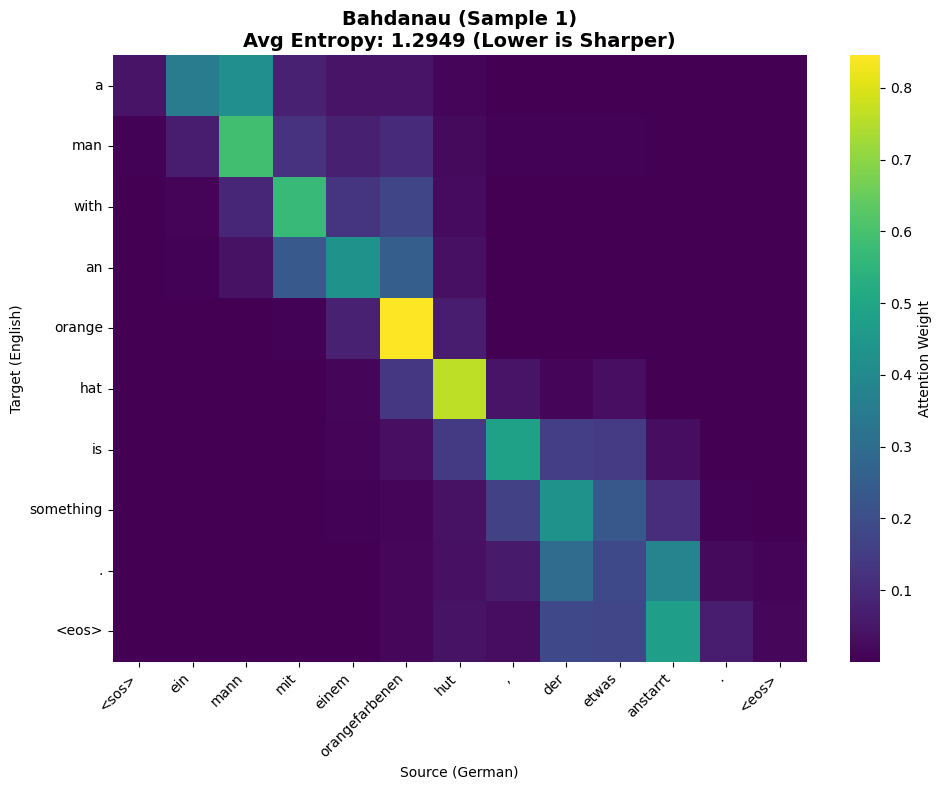

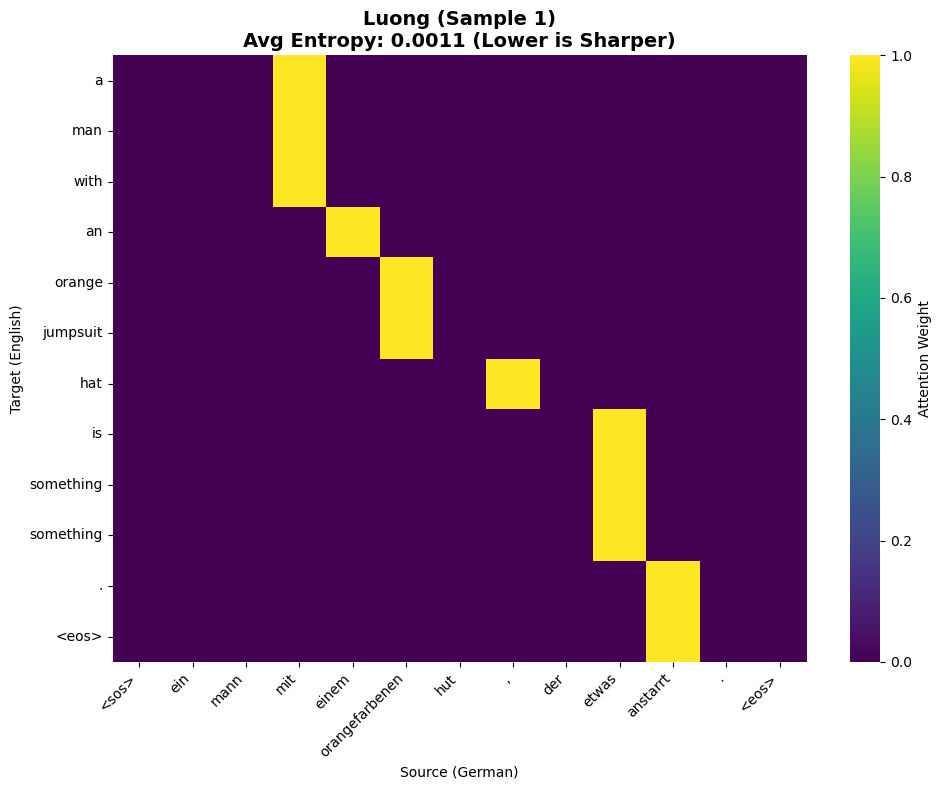

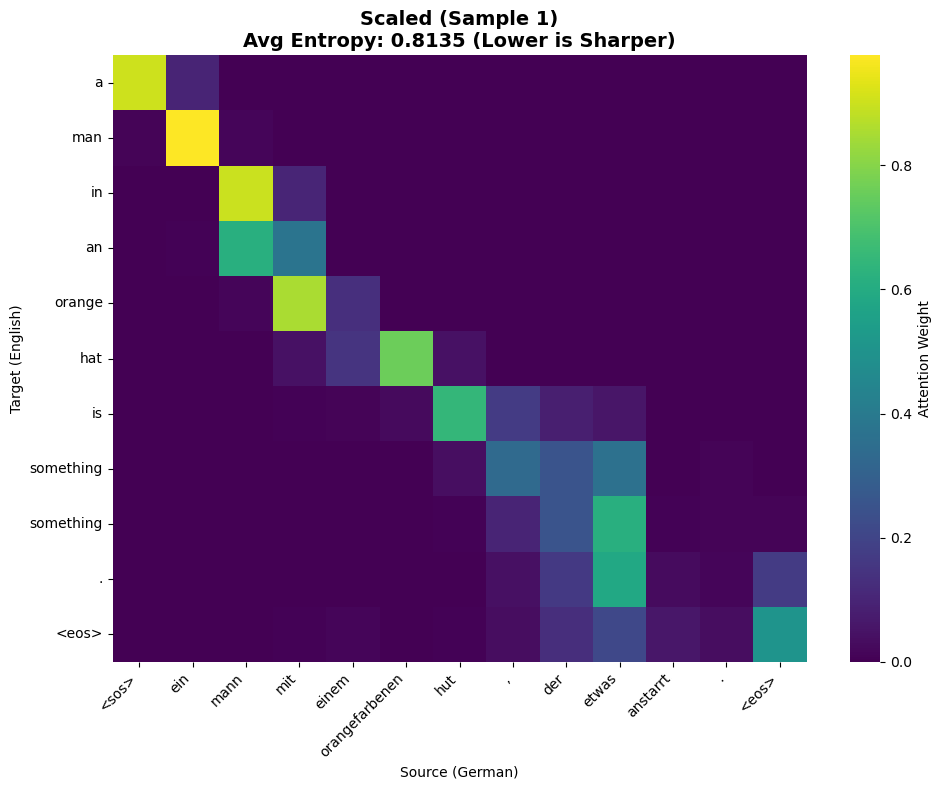


--- SAMPLE 2 ANALYSIS ---
DE: ein boston terrier läuft über saftig-grünes gras vor einem weißen zaun .
EN: a boston terrier is running on lush green grass in front of a white fence .


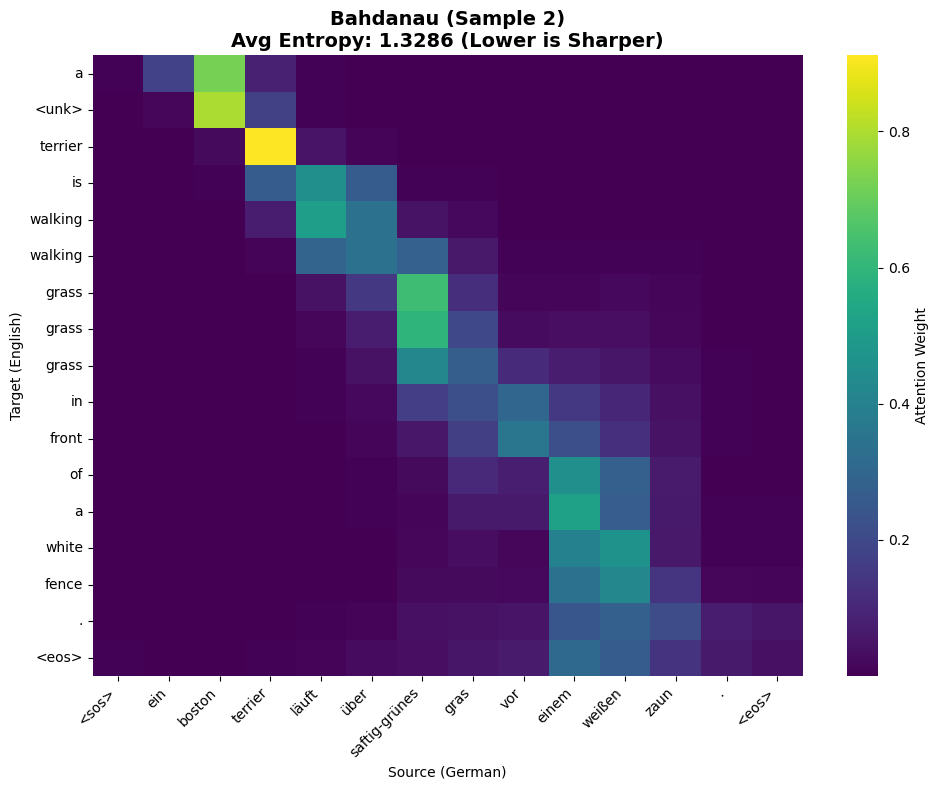

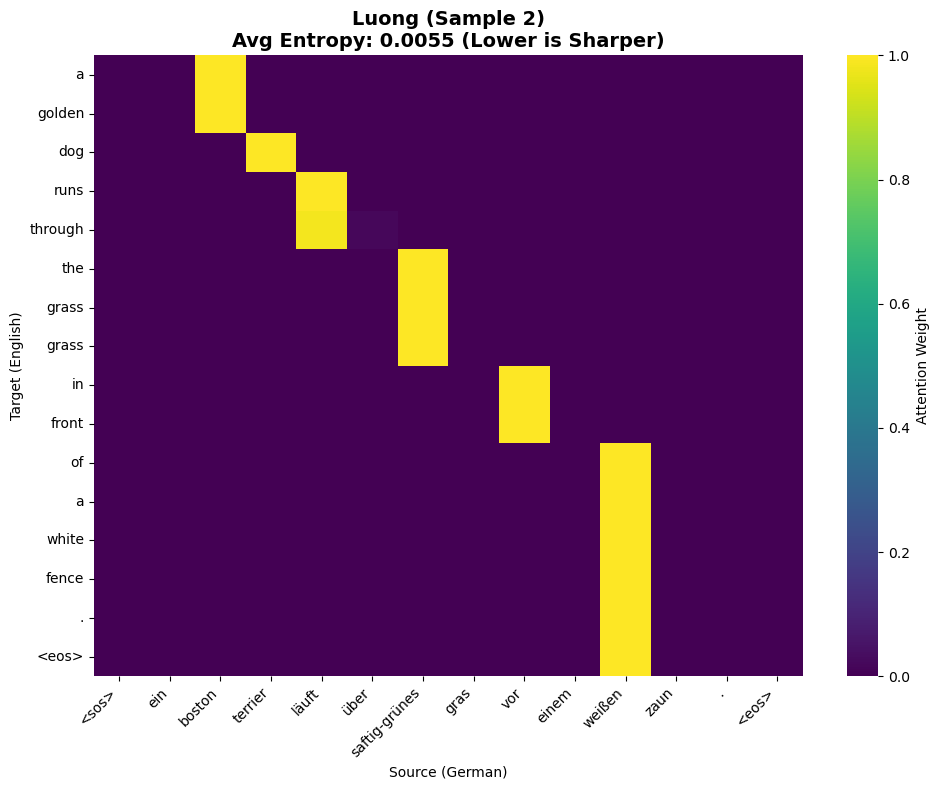

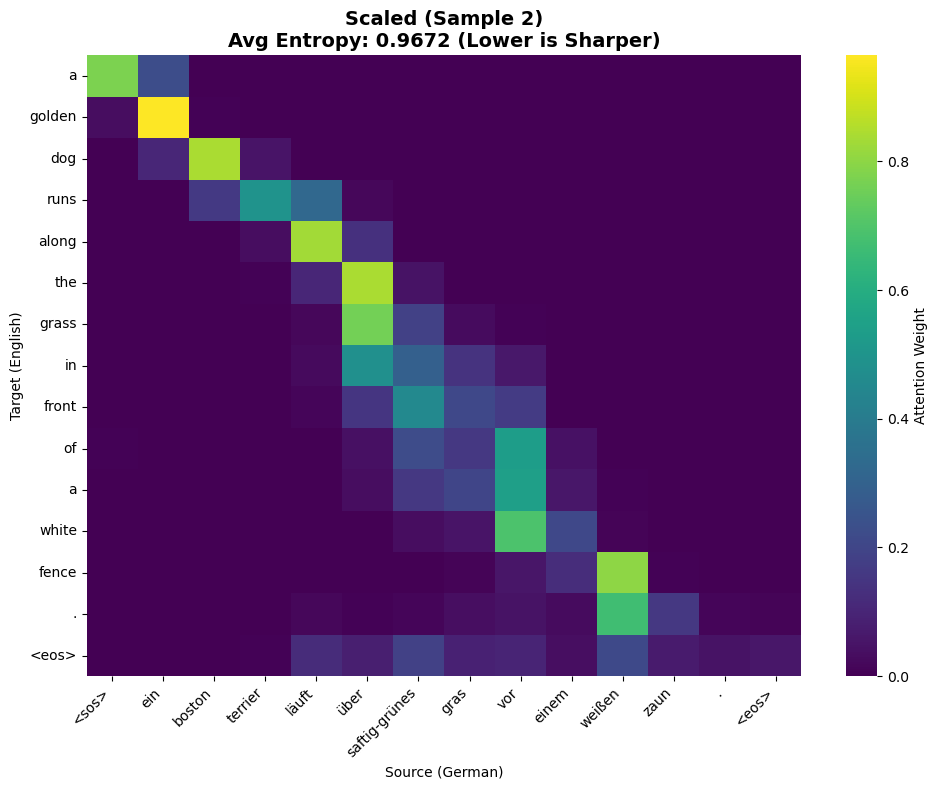


--- SAMPLE 3 ANALYSIS ---
DE: ein mädchen in einem karateanzug bricht ein brett mit einem tritt .
EN: a girl in karate uniform breaking a stick with a front kick .


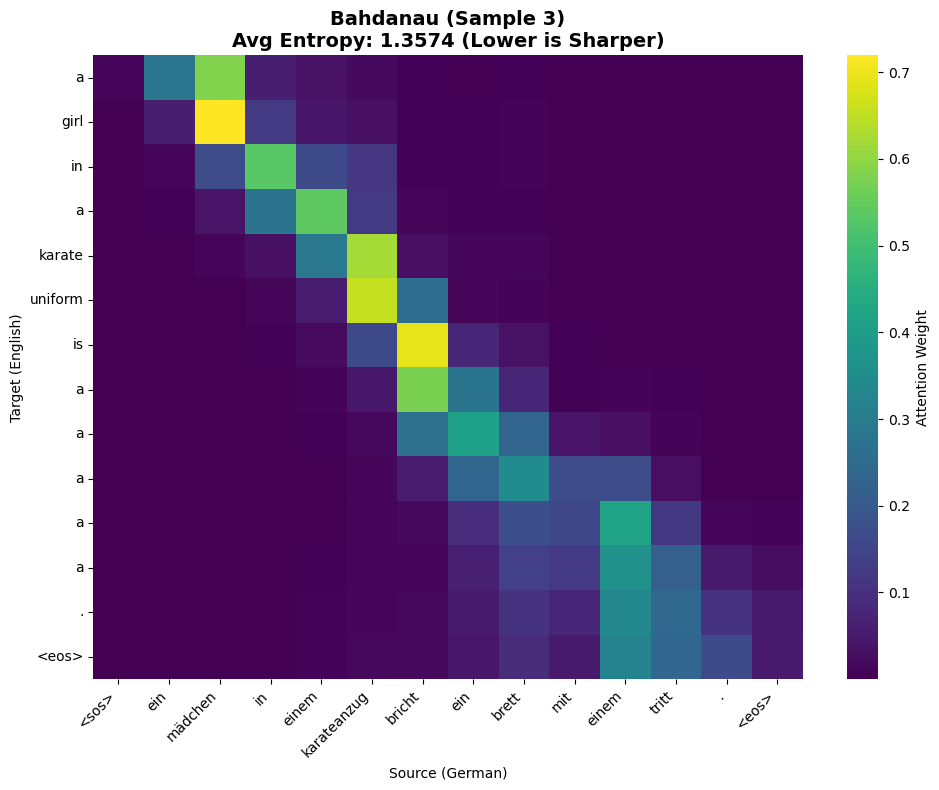

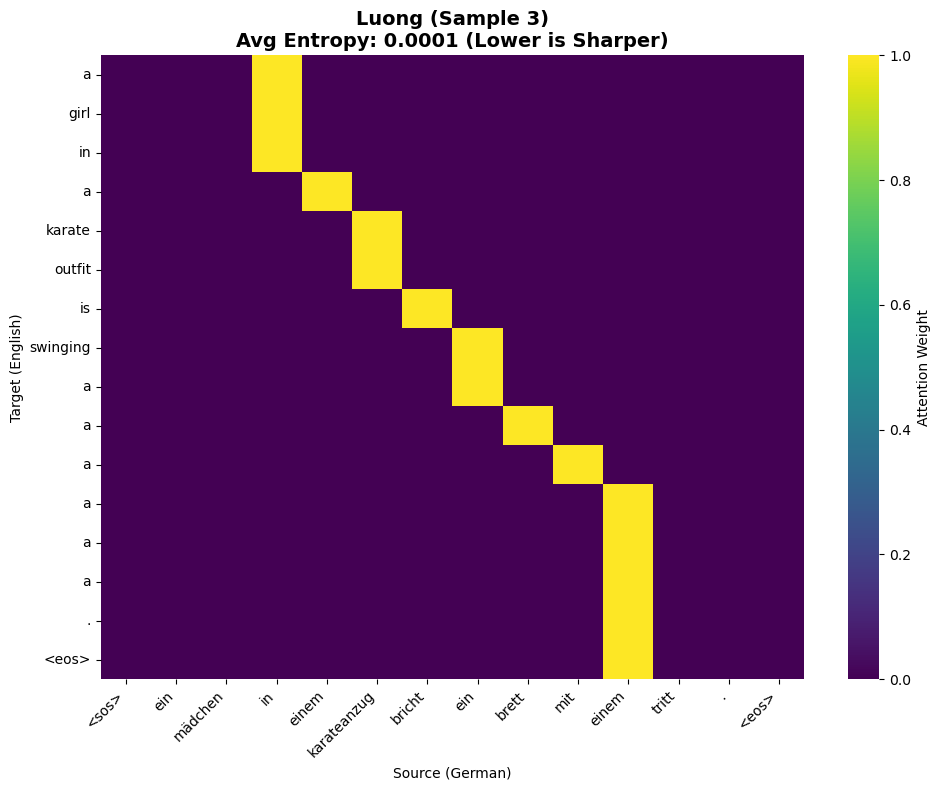

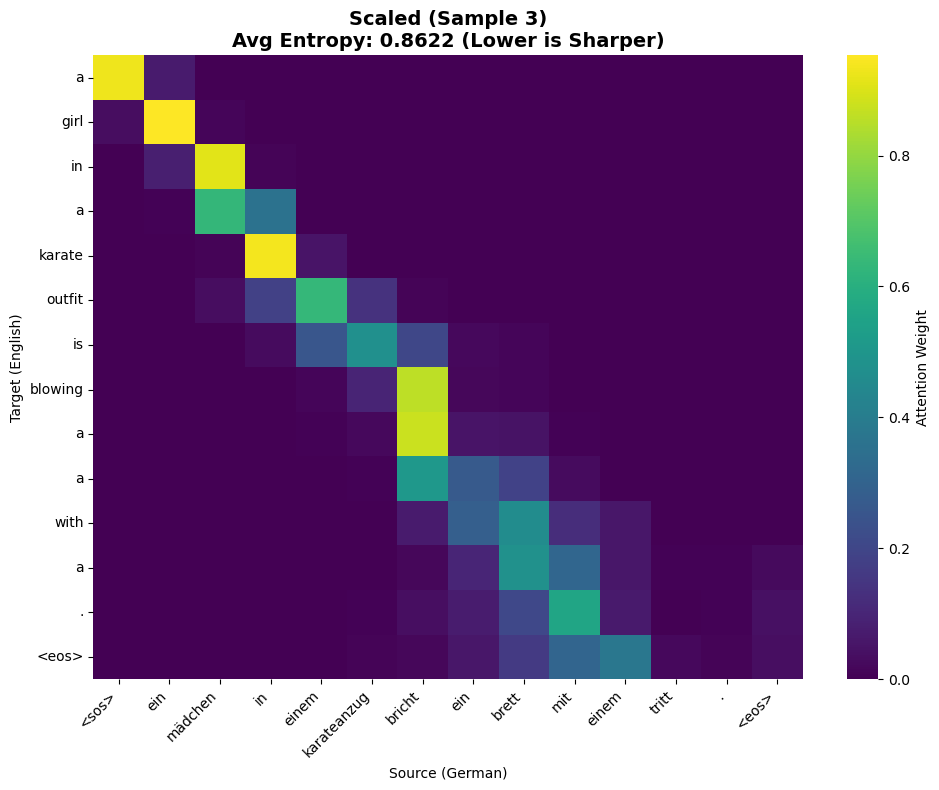


--- SAMPLE 4 ANALYSIS ---
DE: fünf leute in winterjacken und mit helmen stehen im schnee mit schneemobilen im hintergrund .
EN: five people wearing winter jackets and helmets stand in the snow , with snowmobiles in the background .


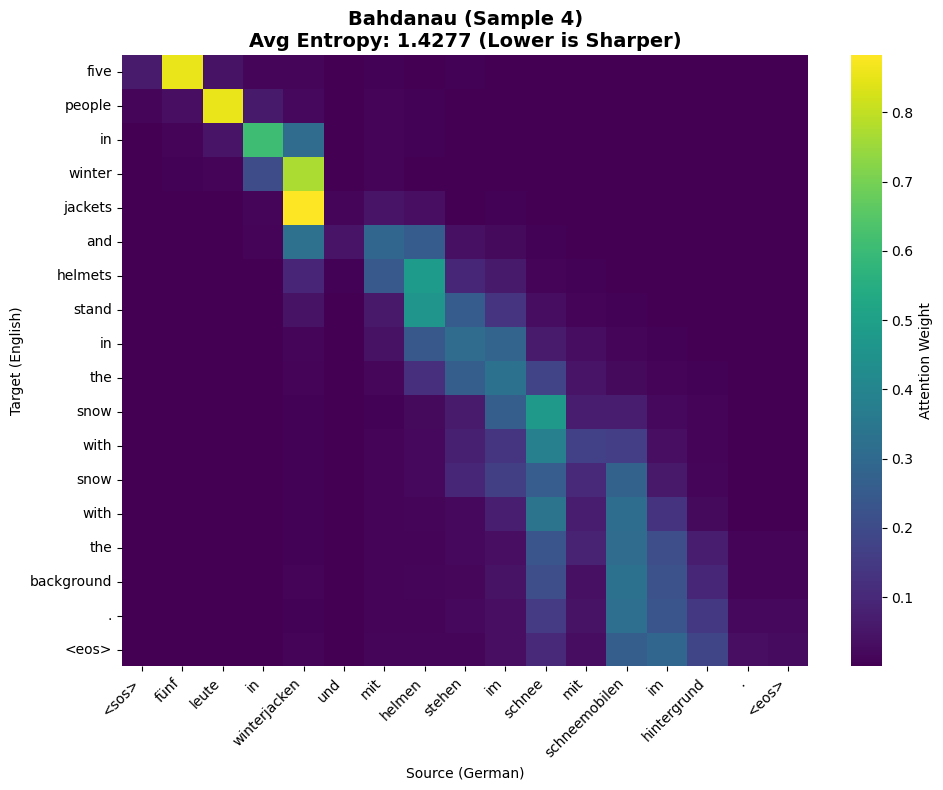

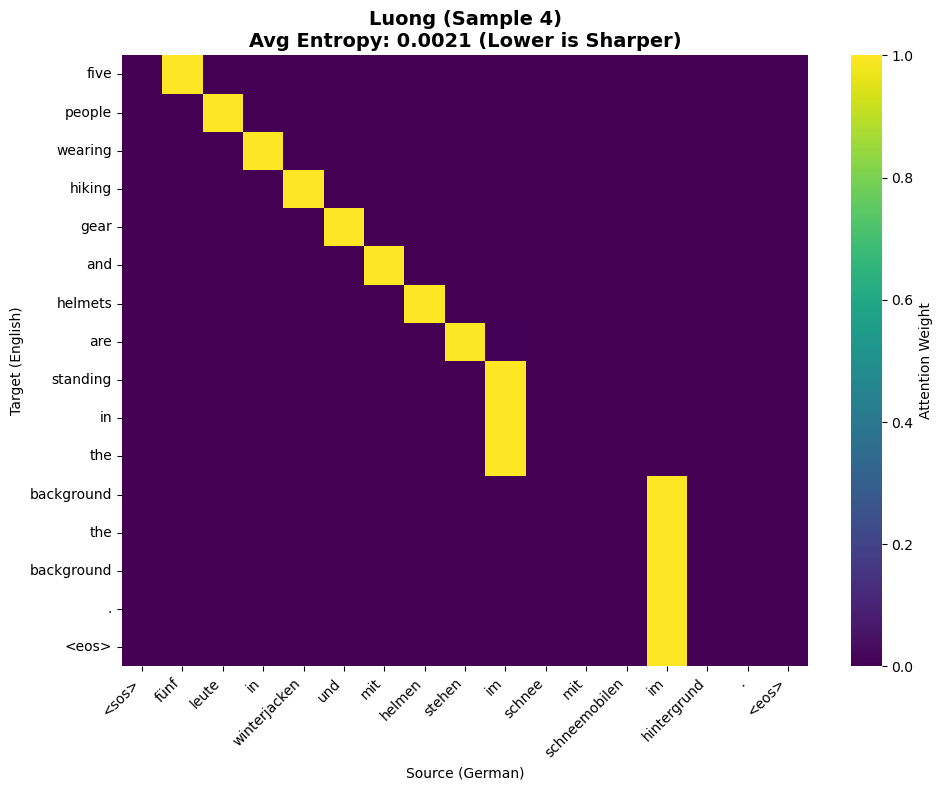

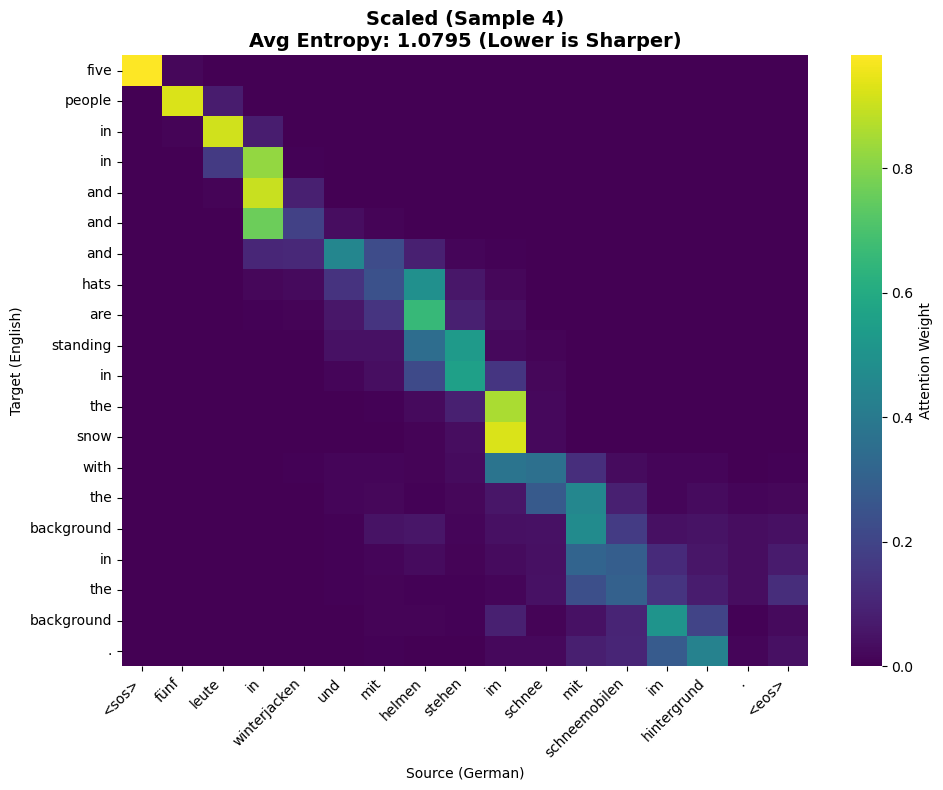


--- SAMPLE 5 ANALYSIS ---
DE: leute reparieren das dach eines hauses .
EN: people are fixing the roof of a house .


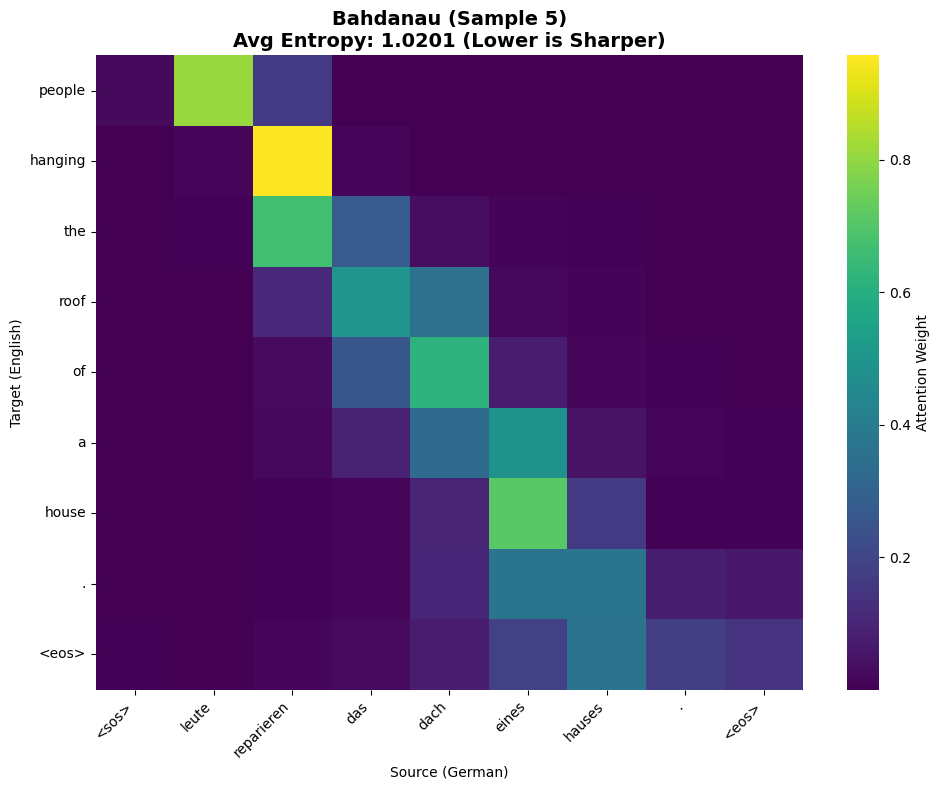

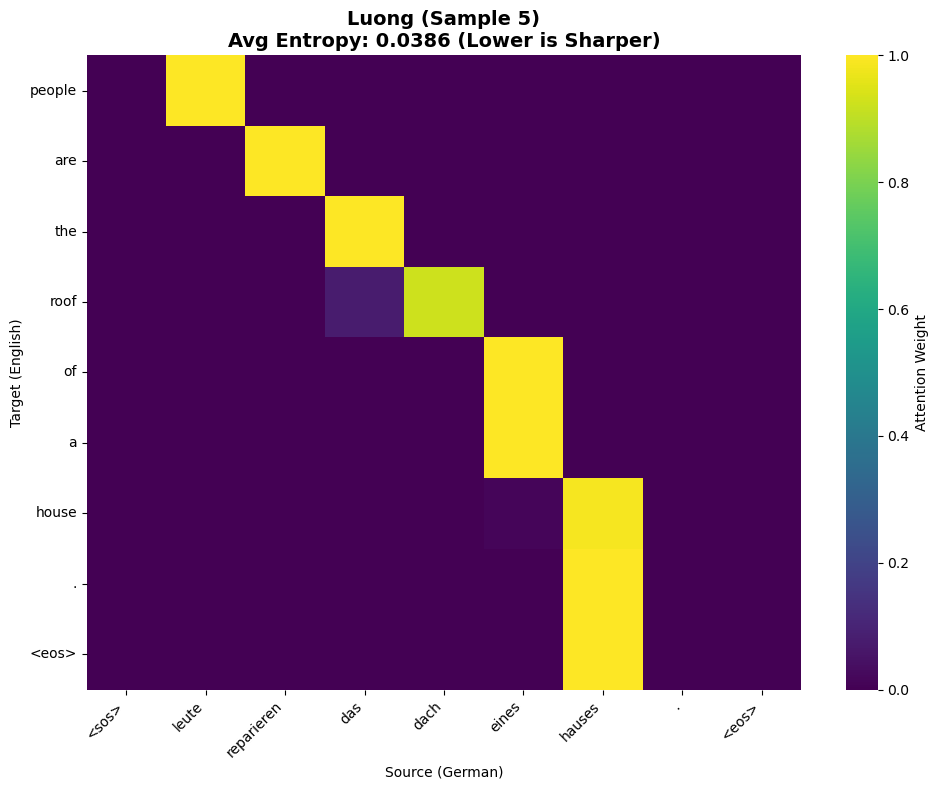

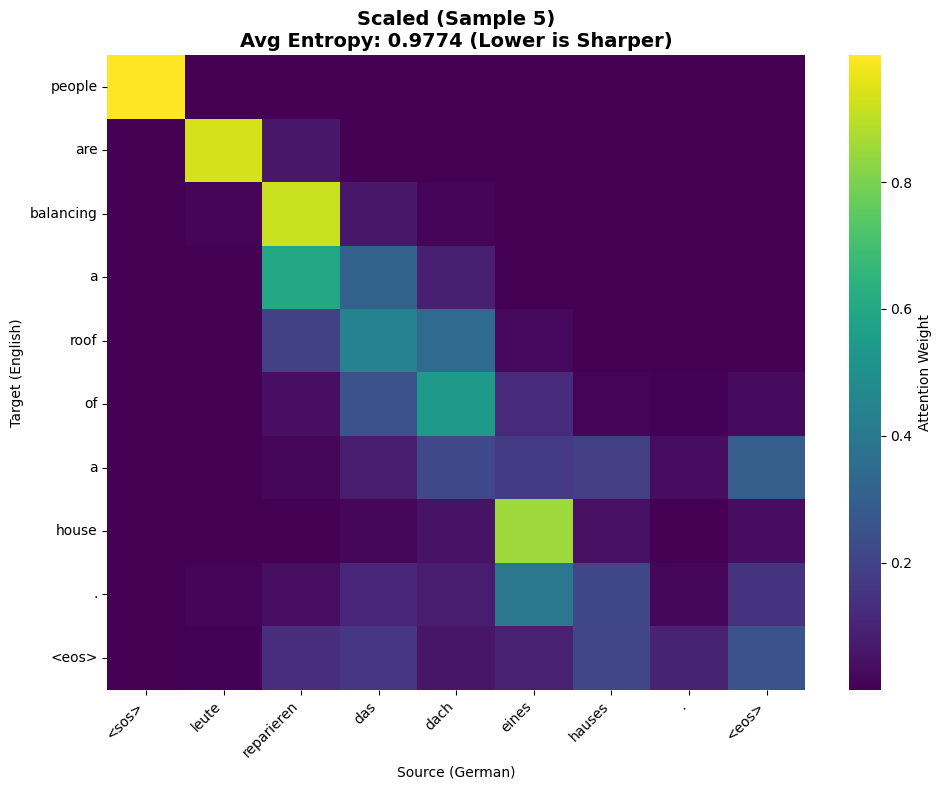


AVERAGE ENTROPY (SHARPNESS) ANALYSIS
Bahdanau   | Avg Entropy: 1.2857 | Sharpness: High
Luong      | Avg Entropy: 0.0095 | Sharpness: High
Scaled     | Avg Entropy: 0.9400 | Sharpness: High


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy

print("=" * 70)
print("QUALITATIVE ANALYSIS: VISUALIZATION AND ENTROPY ANALYSIS ON 5 SAMPLES")
print("=" * 70)
#Helper function to calculate attention entropy
def calculate_attention_entropy(attention_matrix):
    """
    Calculate average entropy of attention distributions across all decoder time steps.
    Lower entropy indicates sharper attention.
    """
    # Attention_matrix: numpy array of shape (trg_len, src_len)
    row_entropies = []
    for row in attention_matrix:
        row = np.array(row) + 1e-9
        row = row / row.sum()
        ent = entropy(row)
        row_entropies.append(ent)

    return np.mean(row_entropies)


def visualize_attention(model, model_name, src_tokens, trg_tokens, sample_id, max_trg_len=20):
    model.eval()

    src_indices = [src_vocab.get(token, UNK_IDX) for token in src_tokens]
    src_indices = [SOS_IDX] + src_indices + [EOS_IDX]
    src_tensor = torch.tensor(src_indices, dtype=torch.long, device=device).unsqueeze(1)
    
    
    with torch.no_grad():
        encoder_outputs, encoder_hidden = model.encoder(src_tensor)
        
        # Bridge: encoder hidden -> decoder hidden (translate_sentence ile aynı)
        n_layers = model.encoder.n_layers
        batch_size = encoder_hidden.shape[1]
        hid_dim = model.encoder.hid_dim
        
        # 1. View: Separate layers and directions
        encoder_hidden = encoder_hidden.view(n_layers, 2, batch_size, hid_dim)
        
        # 2. Cat: Combine forward and backward hidden states
        encoder_hidden_cat = torch.cat((encoder_hidden[:, 0, :, :], encoder_hidden[:, 1, :, :]), dim=2)
        decoder_hidden = torch.tanh(model.fc_hidden(encoder_hidden_cat))

    trg_indices = [SOS_IDX]
    input_token = torch.tensor([SOS_IDX], dtype=torch.long, device=device)
    attention_weights_list = []

    for _ in range(max_trg_len):
        prediction, decoder_hidden, attn_weights = model.decoder(input_token, decoder_hidden, encoder_outputs)
        attention_weights_list.append(attn_weights.detach().cpu().squeeze(0).numpy())
        top1_index = prediction.argmax(1)
        trg_indices.append(top1_index.item())
        if top1_index.item() == EOS_IDX: break
        input_token = top1_index

    attention_matrix = np.array(attention_weights_list)

    avg_entropy = calculate_attention_entropy(attention_matrix)

    #Visualization
    src_display = ['<sos>'] + src_tokens + ['<eos>']
    trg_display = [trg_itos[idx] for idx in trg_indices[1:]] # <sos> hariç

    # Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix,
                xticklabels=src_display,
                yticklabels=trg_display,
                cmap='viridis', cbar_kws={'label': 'Attention Weight'})

    plt.xlabel('Source (German)')
    plt.ylabel('Target (English)')
    plt.title(f'{model_name} (Sample {sample_id})\nAvg Entropy: {avg_entropy:.4f} (Lower is Sharper)',
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Dosya ismine sample id ekle (üstüne yazmasın)
    filename = f'attn_{model_name.split()[0].lower()}_sample{sample_id}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

    return avg_entropy

# (Task 2c) ---
models_for_viz = {
    'Bahdanau': model_1_eval,
    'Luong': model_2_eval,
    'Scaled': model_3_eval
}

entropy_results = {'Bahdanau': [], 'Luong': [], 'Scaled': []}

# İlk 5 örneği seç
for i in range(5):
    example = tokenized_datasets['test'][i]
    src = example['src_tokens']
    trg = example['trg_tokens']

    print(f"\n--- SAMPLE {i+1} ANALYSIS ---")
    print(f"DE: {' '.join(src)}")
    print(f"EN: {' '.join(trg)}")

    for name, model in models_for_viz.items():
        ent = visualize_attention(model, name, src, trg, sample_id=i+1)
        entropy_results[name].append(ent)

# --- ENTROPİ ÖZETİ (Task 2e) ---
print("\n" + "="*50)
print("AVERAGE ENTROPY (SHARPNESS) ANALYSIS")
print("="*50)
for name, entropies in entropy_results.items():
    avg_ent = np.mean(entropies)
    sharpness = "High" if avg_ent < 1.5 else "Low"
    print(f"{name:<10} | Avg Entropy: {avg_ent:.4f} | Sharpness: {sharpness}")

## Entropy-Performance Correlation
Analyzes Pearson correlation between attention entropy and performance metrics (BLEU, ROUGE, Perplexity).

In [ ]:
# Task (e): Analyze correlation between attention entropy and performance metrics
from scipy.stats import pearsonr

# Calculate average entropy per model (across 5 samples)
entropies = [np.mean(entropy_results['Bahdanau']),
             np.mean(entropy_results['Luong']),
             np.mean(entropy_results['Scaled'])]

# Collect performance metrics (from previous evaluation)
bleu_scores = [bleu_1, bleu_2, bleu_3]
rouge_scores = [rouge_1, rouge_2, rouge_3]
ppl_scores = [test_ppl_1, test_ppl_2, test_ppl_3]

# Compute Pearson correlation: Does sharper attention correlate with better performance?
corr_bleu, p_bleu = pearsonr(entropies, bleu_scores)
corr_rouge, p_rouge = pearsonr(entropies, rouge_scores)
corr_ppl, p_ppl = pearsonr(entropies, ppl_scores)

print("=" * 60)
print("ENTROPY-PERFORMANCE CORRELATION ANALYSIS")
print("=" * 60)
print(f"\n{'Metric':<15} {'Correlation':<15} {'p-value':<10} {'Interpretation'}")
print("-" * 60)
print(f"{'BLEU':<15} {corr_bleu:+.3f}          {p_bleu:.3f}      ", end="")
print("Sharp attention better" if corr_bleu < 0 else "Diffuse attention better")
print(f"{'ROUGE':<15} {corr_rouge:+.3f}          {p_rouge:.3f}      ", end="")
print("Sharp attention better" if corr_rouge < 0 else "Diffuse attention better")
print(f"{'Perplexity':<15} {corr_ppl:+.3f}          {p_ppl:.3f}      ", end="")
print("Sharp attention better" if corr_ppl > 0 else "Diffuse attention better")

print("\n" + "=" * 60)
print("FULL COMPARISON")
print("=" * 60)
models = ['Bahdanau', 'Luong', 'Scaled']
print(f"{'Model':<12} {'BLEU':<8} {'ROUGE':<8} {'PPL':<8} {'Entropy':<10}")
print("-" * 60)
for i, name in enumerate(models):
    print(f"{name:<12} {bleu_scores[i]:.4f}   {rouge_scores[i]:.4f}   "
          f"{ppl_scores[i]:.2f}   {entropies[i]:.4f}")

ENTROPY-PERFORMANCE CORRELATION ANALYSIS

Metric          Correlation     p-value    Interpretation
------------------------------------------------------------
BLEU            +0.980          0.127      Diffuse attention better
ROUGE           +0.999          0.028      Diffuse attention better
Perplexity      -0.842          0.363      Diffuse attention better

FULL COMPARISON
Model        BLEU     ROUGE    PPL      Entropi   
------------------------------------------------------------
Bahdanau     0.2850   0.5889   26.76   1.2857
Luong        0.2438   0.5489   30.49   0.0095
Scaled       0.2820   0.5797   29.66   0.9400


## Correlation Scatter Plots
Visualizes entropy vs performance metrics with scatter plots showing correlation coefficients for each model.

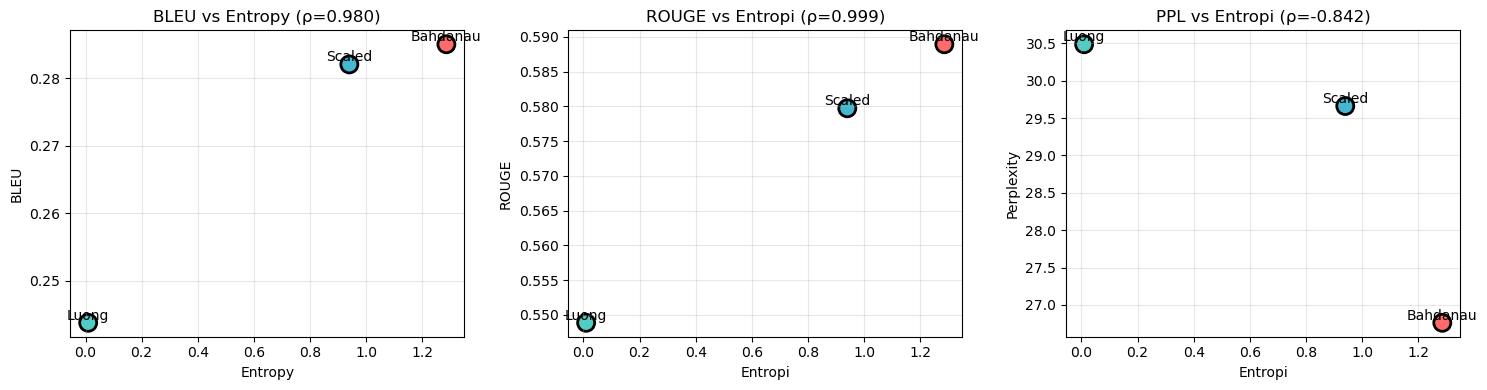


  Task (e) completed: Entropy-performance correlation analyzed


In [24]:
# Visualize entropy-performance correlations with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Distinct color per model

# Plot 1: BLEU vs Entropy
axes[0].scatter(entropies, bleu_scores, s=150, c=colors, edgecolors='black', linewidths=2)
for i, name in enumerate(models):
    axes[0].annotate(name, (entropies[i], bleu_scores[i]), fontsize=10, ha='center', va='bottom')
axes[0].set_xlabel('Entropy')
axes[0].set_ylabel('BLEU')
axes[0].set_title(f'BLEU vs Entropy (ρ={corr_bleu:.3f})')
axes[0].grid(alpha=0.3)

axes[1].scatter(entropies, rouge_scores, s=150, c=colors, edgecolors='black', linewidths=2)
for i, name in enumerate(models):
    axes[1].annotate(name, (entropies[i], rouge_scores[i]), fontsize=10, ha='center', va='bottom')
axes[1].set_xlabel('Entropi')
axes[1].set_ylabel('ROUGE')
axes[1].set_title(f'ROUGE vs Entropi (ρ={corr_rouge:.3f})')
axes[1].grid(alpha=0.3)

axes[2].scatter(entropies, ppl_scores, s=150, c=colors, edgecolors='black', linewidths=2)
for i, name in enumerate(models):
    axes[2].annotate(name, (entropies[i], ppl_scores[i]), fontsize=10, ha='center', va='bottom')
axes[2].set_xlabel('Entropi')
axes[2].set_ylabel('Perplexity')
axes[2].set_title(f'PPL vs Entropi (ρ={corr_ppl:.3f})')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('entropy_performance_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n  Task (e) completed: Entropy-performance correlation analyzed")

## Performance Comparison Visualization
Creates bar charts and radar chart for comprehensive visual comparison of all attention mechanisms.


PERFORMANCE METRICS VISUAL COMPARISON


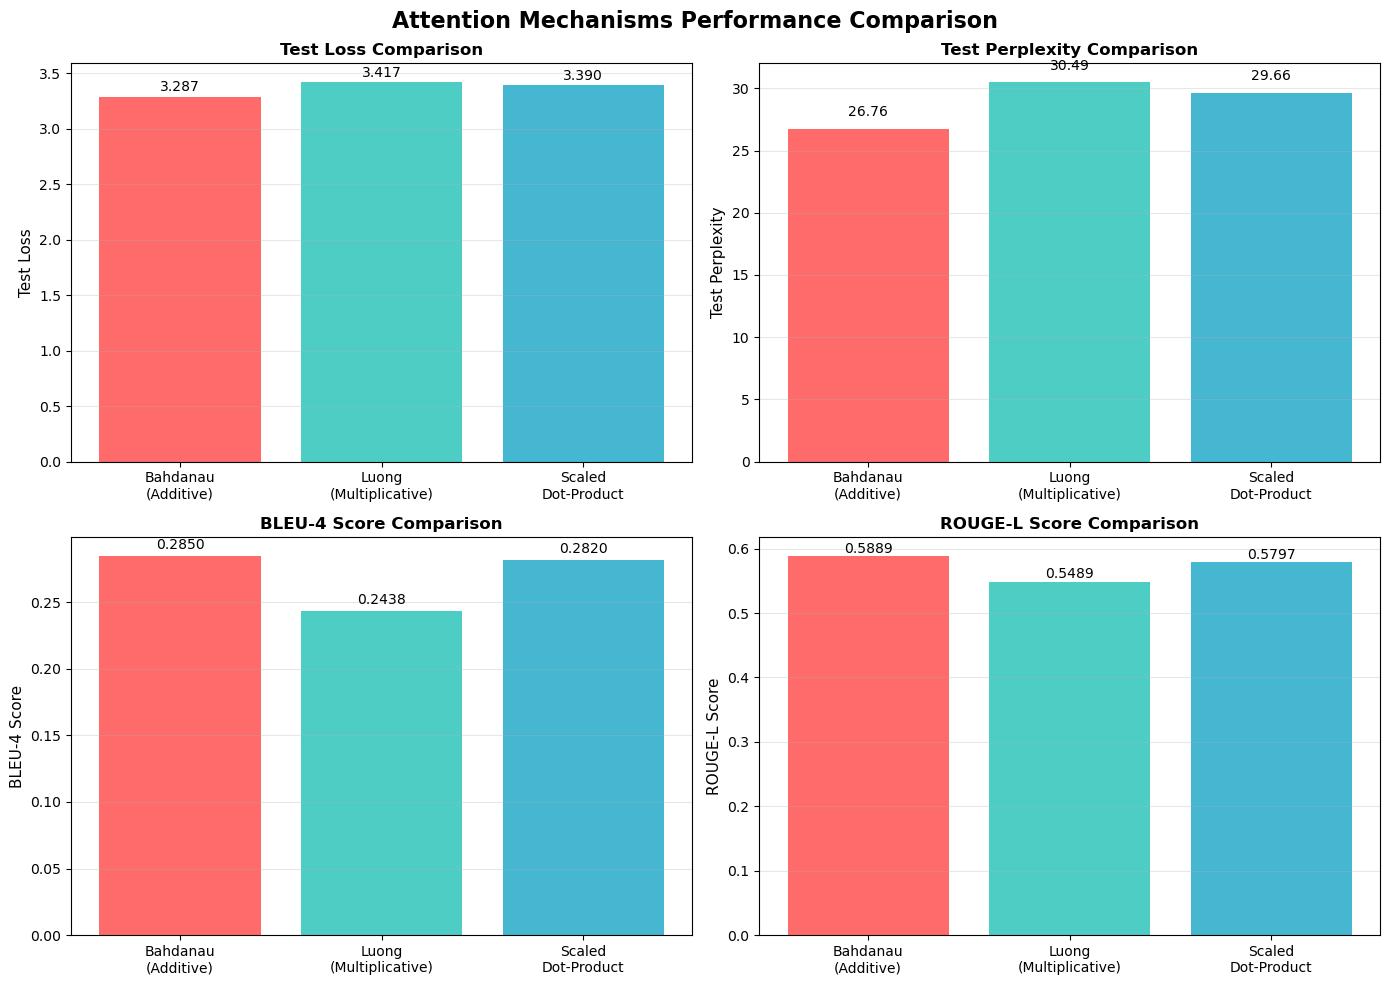


  Performance comparison chart saved as 'attention_mechanisms_comparison.png'


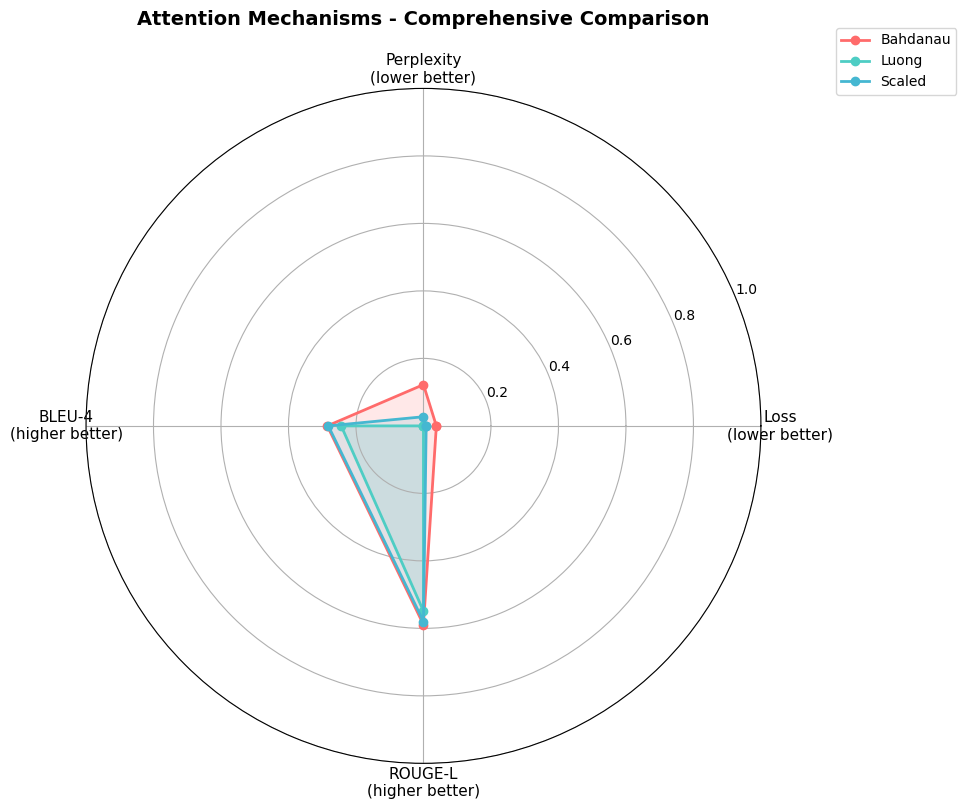

  Radar comparison chart saved as 'attention_mechanisms_radar.png'


In [ ]:


print("\n" + "=" * 70)
print("PERFORMANCE METRICS VISUAL COMPARISON")
print("=" * 70)

# Prepare data for visualization
models_names = ['Bahdanau\n(Additive)', 'Luong\n(Multiplicative)', 'Scaled\nDot-Product']
test_losses = [test_loss_1, test_loss_2, test_loss_3]
test_ppls = [test_ppl_1, test_ppl_2, test_ppl_3]

# Create 2x2 grid of bar charts comparing all metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Attention Mechanisms Performance Comparison', fontsize=16, fontweight='bold')

# Chart 1: Test Loss (lower is better)
axes[0, 0].bar(models_names, test_losses, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_ylabel('Test Loss', fontsize=11)
axes[0, 0].set_title('Test Loss Comparison', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_losses):
    axes[0, 0].text(i, v + 0.05, f'{v:.3f}', ha='center', fontsize=10)

# Test Perplexity comparison
axes[0, 1].bar(models_names, test_ppls, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 1].set_ylabel('Test Perplexity', fontsize=11)
axes[0, 1].set_title('Test Perplexity Comparison', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_ppls):
    axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center', fontsize=10)

# BLEU-4 comparison
axes[1, 0].bar(models_names, bleu_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 0].set_ylabel('BLEU-4 Score', fontsize=11)
axes[1, 0].set_title('BLEU-4 Score Comparison', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(bleu_scores):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=10)

# ROUGE-L comparison
axes[1, 1].bar(models_names, rouge_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 1].set_ylabel('ROUGE-L Score', fontsize=11)
axes[1, 1].set_title('ROUGE-L Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rouge_scores):
    axes[1, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('attention_mechanisms_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n  Performance comparison chart saved as 'attention_mechanisms_comparison.png'")

# Create radar chart for holistic comparison across all metrics
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Normalize all metrics to [0,1] range for fair comparison
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Prepare metrics matrix (invert loss/perplexity since lower is better)
metrics_matrix = np.array([
    [1 - (l / max(test_losses)) for l in test_losses],  # Normalized inverted loss
    [1 - (p / max(test_ppls)) for p in test_ppls],      # Normalized inverted perplexity
    bleu_scores,  # Higher is better (no inversion needed)
    rouge_scores  # Higher is better (no inversion needed)
])

# Define radar chart axes
categories = ['Loss\n(lower better)', 'Perplexity\n(lower better)', 'BLEU-4\n(higher better)', 'ROUGE-L\n(higher better)']
N = len(categories)

# Calculate angles for radar chart (divide circle into N equal parts)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the circle

# Plot each model as separate line on radar chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
model_labels = ['Bahdanau', 'Luong', 'Scaled']

for idx, (color, label) in enumerate(zip(colors, model_labels)):
    values = metrics_matrix[:, idx].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=label, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Attention Mechanisms - Comprehensive Comparison', size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('attention_mechanisms_radar.png', dpi=300, bbox_inches='tight')
plt.show()

print("  Radar comparison chart saved as 'attention_mechanisms_radar.png'")
